# Analysis of the sister-city network
## Part 1 : Scraping 
We start off by writing a simple scraping algorithm that first yields us all the countries

In [1]:
%matplotlib inline 
from bs4 import BeautifulSoup
from urllib.request import urlopen
PARSER = "html.parser"

url = "http://en.sistercity.info/countries/"

html = urlopen(url).read()
soup = BeautifulSoup(html, PARSER)

countries = soup.find_all("a", href=lambda href: href and href.startswith("/countries/"))    

Once we have all the countries we simply apply the same idea to get all the cities and respective sister cities. We can then easily generate the graph after cleaning the html. For the sake of simplicity starting off I decided to limit the order of the graph to 100, that is I restricted the number of city nodes to 100.

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlopen
from bs4 import BeautifulSoup

PARSER = "html.parser"
G = nx.Graph()

def yield_soup(url):
    html = urlopen(url).read()
    soup = BeautifulSoup(html, PARSER)
    return soup

def generate_edges(country_url):
    country_soup = yield_soup(country_url)
    cities = country_soup.find_all("a", href=lambda href: href and href.startswith("/sister-cities/"))

    for city in cities:
        city_url = "http://en.sistercity.info" + city["href"]
        city_soup = yield_soup(city_url)
        sister_cities = city_soup.find_all("div", {"class": "label"})
        sister_cities = [sister_city.text for sister_city in sister_cities]

        # Cleaning the data 
        sister_cities = [sister_city.replace("\xa0→", "").replace("\xa0⇄", "").replace("\xa0←", "") for sister_city in sister_cities]
        for sister_city in sister_cities:
            G.add_edge(city.text, sister_city)

for country in countries:
    country_url = "http://en.sistercity.info" + country["href"]
    if len(G) < 100:
        generate_edges(country_url)

## Part 2 : Displaying 
Now if we just use the basic layout for drawing networks then there is alot of overlap with the nodes which makes everything quite unreadable.

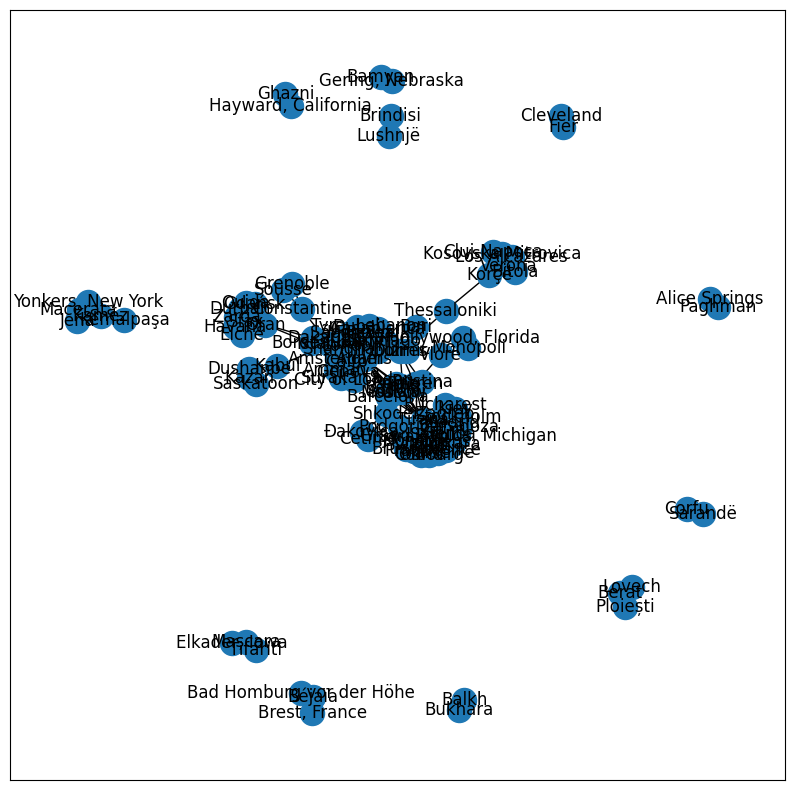

In [3]:
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, with_labels=True)
plt.show()

So the first observation should be that the nodes are too close together. Also the text overflows the nodes quite heavily. Furhtermore the different components of the graph are scattered quite sporadically. So to fix this we can address each issue step by step. 

**issue 1 - Nodes too close**

To solve the nodes being to close we can use the spring layout. Which quoting the documentation : 
```
... simulates a force-directed representation of the network treating edges as springs holding nodes close, while treating nodes as repelling objects, sometimes called an anti-gravity force
```

The important parameter here is `k` which as it increases moves nodes further apart from oneanother. I could not figure out any nice way to find a nice value besides brute force so after a little bit of testing I settled on $20\times \frac{1}{\sqrt{\text{number of nodes}}}$

**issue 2 - Node sizes** 

Clearly we want the nodes to cover a larger portion of the word to make it look less awkward, to do this we can simply increase the `node_size` argument and maybe also change the color of the nodes and edges to something more pastel to give the graph a less harsh appearance.

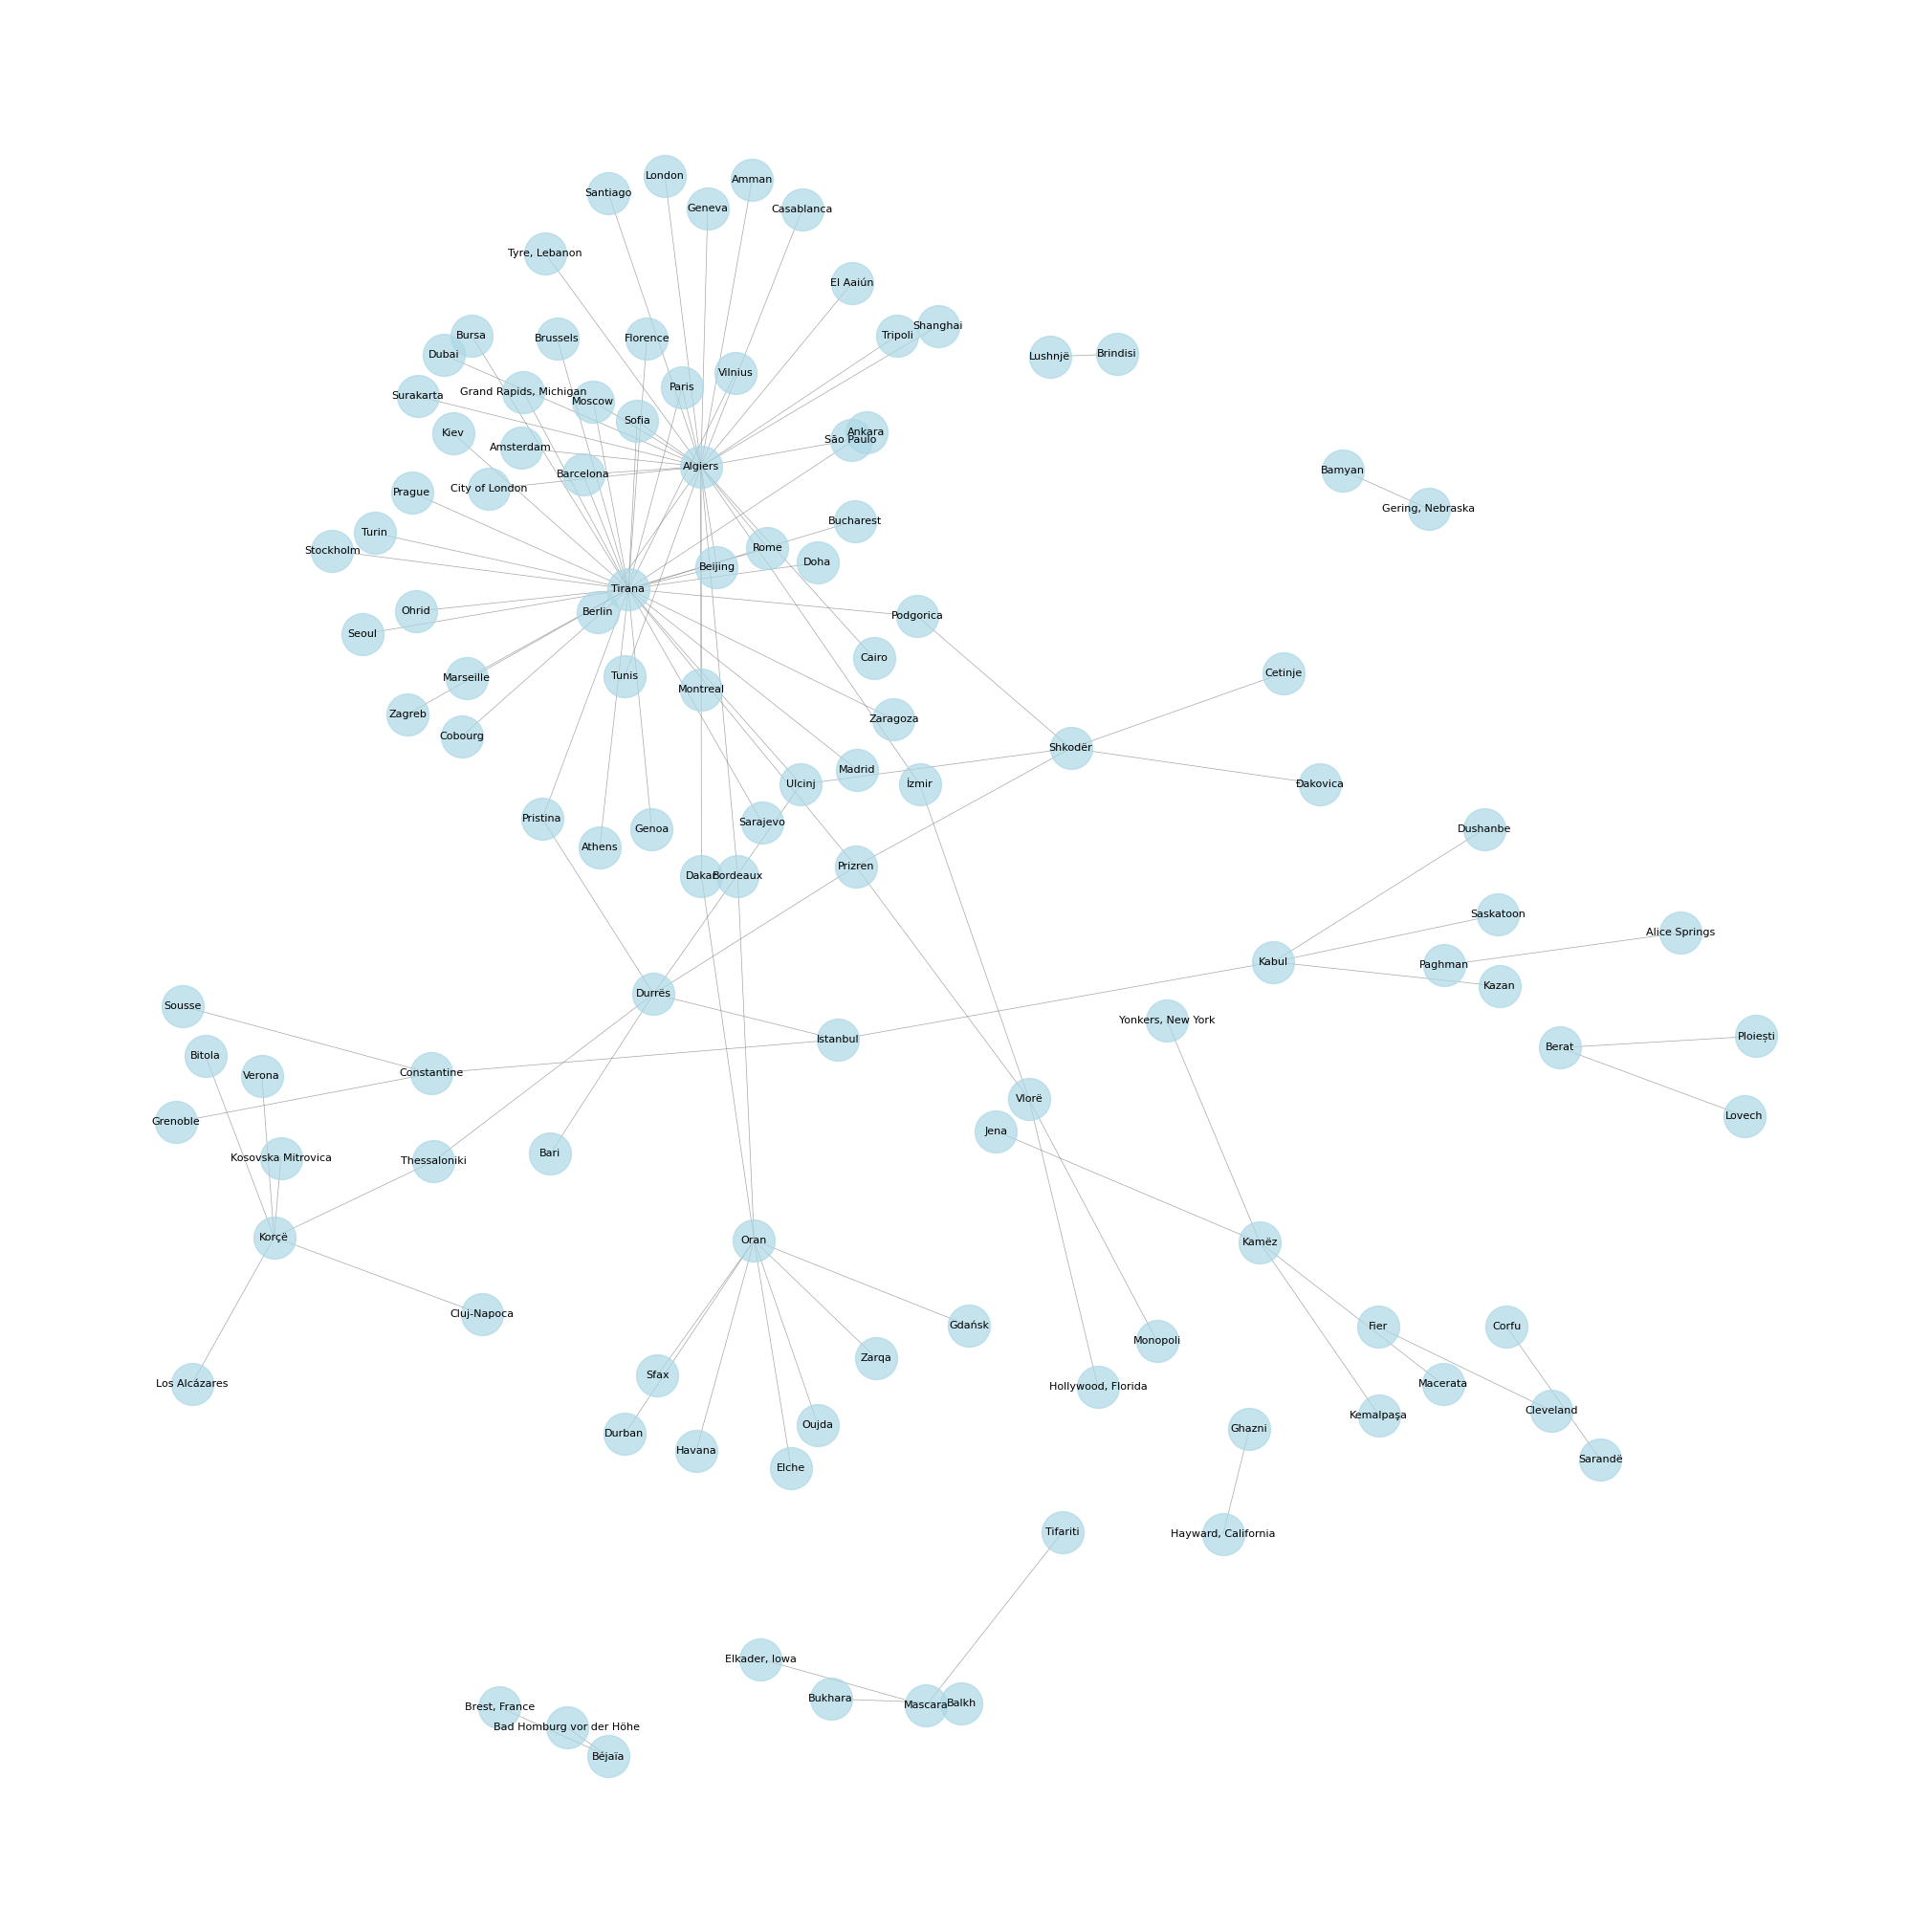

In [4]:
# controls the graph layout
pos = nx.spring_layout(G, 
                       k=20*1/np.sqrt(len(G.nodes())), 
                       iterations=400,
                       scale=1000)

plt.figure(figsize=(20, 20))

# draw nodes and edges
nx.draw(G, pos=pos, 
        node_size=1000, 
        node_color='lightblue', 
        edge_color='gray', 
        alpha=0.7, 
        width=0.5)

nx.draw_networkx_labels(G, pos=pos, font_size=8)
plt.axis('off')
plt.show()

### 2.1 improving the display using pyvis
One of the most prominant issues which is still apparent is that nodes still overlap to the point where it makes certain labels illegible. Here we could play around a bit more networkx but pyviz, which can interface with networkx, might be better suited moving forwards.

In [5]:
from pyvis.network import Network

net = Network(notebook=True, height="1000px", width="1000px", bgcolor="#222222", font_color="white", cdn_resources='remote')
net.from_nx(G)
net.show("assets/basic_example.html")

assets/basic_example.html


This is alot nicer, now lets see scrape a few more cities and then see what our graph looks like. To improve the performance we can disable dragging of the nodes using the `toggle_drag_nodes(false)` 

In [6]:
for country in countries:
    country_url = "http://en.sistercity.info" + country["href"]
    if len(G) < 500:
        generate_edges(country_url)

In [7]:
net = Network(notebook=True, height="1000px", width="1000px", bgcolor="#222222", font_color="white")
net.from_nx(G)
net.show("assets/more_cities.html")

assets/more_cities.html


### 2.2 Final refinements 
One final change I think would improve the visualization would be to make the degree centrality of a node correspond to its size. This is a simple addition to our display code.

In [8]:
net = Network(notebook=True, height="1000px", width="100%", bgcolor="#222222", font_color="white")
net.from_nx(G)
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')
net.toggle_drag_nodes(False)
net.show("assets/all_cities.html")

assets/all_cities.html


## Part 3: Analysis
One of the first things I thought would be cool to see would be the network of the sister cities visualized ontop of the worldmap. Similar to the following [image](https://www.researchgate.net/figure/Connections-between-sister-cities-visualised-on-a-world-map-Shorter-connections-are_fig2_235356930) but at a higher resolution.
Breaking this problem down : 
1. I need to get some high resolution image of the world map, something which would hopefully not degrade too much in quality with zooming.
2. I would somehow need to correspond each node representing a city with its coordinate on the world map. 
3. Once I have that I should in theory just be able to render the graph based off the edges I already have stored.

### 3.1 Rendering the image
So the first thing that comes to mind with "high resolution that doesnt degrade in quality with scaling" is obviously svg, so now the challanges becomes how do we actually display the svg then how do we have the network overlay the svg. 
Matplotlib can apparently display images and also interface with networkx so lets give that a go.

In [129]:
import svgutils.compose as sc
from IPython.display import SVG

svg_path = "assets/world.svg"
fig, ax = plt.subplots(figsize=(4, 4))

fig.savefig("assets/cover.svg", transparent=True)
plt.close(fig) # supress the output

# Here starts the assembling using svgutils
sc.Figure("10cm", "10cm",
          sc.Text("A", 1, 1, size=0.5, weight='bold'),
          sc.SVG("assets/world.svg").scale(0.0025),
          sc.SVG("assets/cover.svg").scale(0.025),
).save("assets/compose.svg")

SVG("assets/compose.svg")